## Импорт библиотек

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import neattext.functions as nfx
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import pickle
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
from collections import Counter


## Основные классы и функции - токенизатор, классификатор и др.

In [3]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, embedding_weights=None, trainable_embeddings=False):
        super().__init__()

        if embedding_weights is not None:
            self.embedding = nn.Embedding.from_pretrained(embedding_weights, freeze=not trainable_embeddings)
        else:
            self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # Применяем многослойную реккурентную нейросеть с долговременной краткосрочной памятью
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, 256)
        self.relu = nn.ReLU() # Активация ReLU
        self.fc2 = nn.Linear(256, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, text):
        embedded = self.embedding(text)
        lstm_out, (hidden, cell) = self.lstm(embedded)
        pooled = torch.max(lstm_out, dim=1)[0]

        fc1_out = self.relu(self.fc1(pooled))
        output = self.sigmoid(self.fc2(fc1_out))

        return output

class PyTorchTokenizer:
    def __init__(self, num_words=None):
        self.word_counts = Counter()
        self.word_index = {} # Слова в индексы
        self.index_word = {} # Обратно - индексы в слова
        self.num_words = num_words
        self.oov_token = 1

    def fit_on_texts(self, texts):
        for text in texts:
            for word in text.split():
                self.word_counts[word] += 1

        sorted_words = [word for word, _ in self.word_counts.most_common(self.num_words - 2 if self.num_words else None)]
        self.word_index['<pad>'] = 0 # Служебный токен паддинг для выравнивания длины последовательности
        self.word_index['<unk>'] = self.oov_token # Для слов вне обучающей выборки (Out of vocabulary)

        idx = 2
        for word in sorted_words:
            self.word_index[word] = idx
            idx += 1

        self.index_word = {idx: word for word, idx in self.word_index.items()}

    def texts_to_sequences(self, texts):
        sequences = []
        for text in texts:
            seq = []
            for word in text.split():
                seq.append(self.word_index.get(word, self.oov_token))
            sequences.append(seq)
        return sequences

# Функции для цикла обучения

# Возвращает точность для бинарной классификации.
def binary_accuracy(preds, y):
    # Округляем до ближайшего целого (0 или 1)
    rounded_preds = torch.round(preds)
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

# Тренировка модели
def train(model, loader, optimizer, criterion):
    model.train() # Устанавливаем модель в режим обучения
    epoch_loss = 0
    epoch_acc = 0

    for text, label in tqdm(loader, desc="Обучение"):
        optimizer.zero_grad() # Обнуляем градиенты

        predictions = model(text).squeeze(1) # Делаем предсказания
        loss = criterion(predictions, label.squeeze(1)) # Вычисляем потери
        acc = binary_accuracy(predictions, label.squeeze(1)) # Вычисляем точность

        loss.backward() # Обратное распространение
        optimizer.step() # Обновление весов

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(loader), epoch_acc / len(loader)

# Оценка эффективности модели
def evaluate(model, loader, criterion):
    model.eval() # Устанавливаем модель в режим оценки
    epoch_loss = 0
    epoch_acc = 0

    with torch.no_grad(): # Отключаем расчет градиентов для оценки
        for text, label in tqdm(loader, desc="Оценка"):
            predictions = model(text).squeeze(1)
            loss = criterion(predictions, label.squeeze(1))
            acc = binary_accuracy(predictions, label.squeeze(1))

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(loader), epoch_acc / len(loader)

# Функция для очистки текста
def clean_text(text_series):
    text_length = []
    cleaned_text = []
    for sent in text_series:
        sent = str(sent).lower()
        sent = nfx.remove_special_characters(sent)
        sent = nfx.remove_stopwords(sent)
        text_length.append(len(sent.split()))
        cleaned_text.append(sent)
    return cleaned_text, text_length

def plot_training_history(history):
    """Визуализирует историю обучения"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(history['train_losses'], label='Train Loss')
    ax1.plot(history['test_losses'], label='Test Loss')
    ax1.set_title('Loss')
    ax1.legend()

    ax2.plot(history['train_accs'], label='Train Acc')
    ax2.plot(history['test_accs'], label='Test Acc')
    ax2.set_title('Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.show()

## Загрузка данных для обучения модели классификации, визуализация

Используемое устройство: cuda

Распределение классов в исходных данных:
class
suicide        116037
non-suicide    116037
Name: count, dtype: int64

Распределение классов в обучающей выборке:
class
non-suicide    92830
suicide        92829
Name: count, dtype: int64


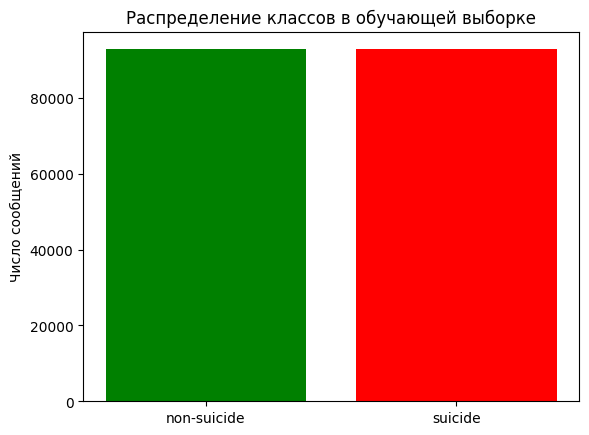

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide
...,...,...,...
116032,174354,"Anyone wanna chat? Not sad or anything, just c...",non-suicide
116033,174355,I wish I was deadTW TW TW patriarchal dumpster...,suicide
116034,174356,I can't tell Am I depressed?\n\nAm I coming to...,non-suicide
116035,174357,Chat? Please help :/Been feeling really suicid...,suicide


In [4]:
# Проверка наличия GPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {DEVICE}")

#Загрузка данных
data = pd.read_csv("Suicide_Detection.csv")

# Проверка распределения классов
print("\nРаспределение классов в исходных данных:")
print(data['class'].value_counts())

# Разделение данных на обучающую и тестовую выборки
train_data, test_data = train_test_split(data, test_size=0.2, random_state=10, stratify=data['class']) # Добавим stratify

print("\nРаспределение классов в обучающей выборке:")
print(train_data['class'].value_counts())

# Визуализация распределения классов
class_counts = train_data['class'].value_counts()

fig, ax = plt.subplots()

classes = class_counts.index.values
counts = class_counts.values

ax.bar(classes, counts, color=['g', 'r'])

ax.set_ylabel("Число сообщений")
ax.set_title("Распределение классов в обучающей выборке")

plt.show()
data.head(116037)

## Очистка текста для модели, создание и обучение токенизатора

In [5]:
cleaned_train_text, train_text_length = clean_text(train_data.text) #
cleaned_test_text, test_text_length = clean_text(test_data.text)

# Токенизация и паддинг
MAX_LEN = 50

# Создаем и обучаем токенизатор
tokenizer = PyTorchTokenizer()
tokenizer.fit_on_texts(cleaned_train_text)

train_text_seq = tokenizer.texts_to_sequences(cleaned_train_text)
train_text_pad = np.array([np.pad(seq[:MAX_LEN], (0, max(0, MAX_LEN - len(seq))), 'constant', constant_values=0)
                           for seq in train_text_seq])

test_text_seq = tokenizer.texts_to_sequences(cleaned_test_text)
test_text_pad = np.array([np.pad(seq[:MAX_LEN], (0, max(0, MAX_LEN - len(seq))), 'constant', constant_values=0)
                          for seq in test_text_seq])

torch.save(tokenizer, 'tokenizer_pytorch.pkl')

# Кодирование меток
lbl_target = LabelEncoder()
train_output = lbl_target.fit_transform(train_data['class'])
test_output = lbl_target.transform(test_data['class'])

# Выводим преобразованные метки, чтобы убедиться
print("\nПример преобразованных меток (0 или 1):")
print(train_output[:10])
print(f"Классы: {lbl_target.classes_}")


Пример преобразованных меток (0 или 1):
[0 0 0 0 0 0 1 0 1 1]
Классы: ['non-suicide' 'suicide']


## Загрузка эмбендинга GloVe

In [6]:
# Загрузка GloVe
glove_path = 'GloVe.pkl'

with open(glove_path, 'rb') as fp:
    glove_embedding = pickle.load(fp)

# Создание матрицы эмбеддингов
VOCAB_SIZE = len(tokenizer.word_index)
EMBEDDING_DIM = 300 # Размерность GloVe эмбеддингов в файле - 300 измерений для 840 миллиардов токенов

embedding_matrix = np.zeros((VOCAB_SIZE + 1, EMBEDDING_DIM), dtype=np.float32)
for word, idx in tqdm(tokenizer.word_index.items(), desc="Создание матрицы эмбендингов"):
    embedding_vector = glove_embedding.get(word)
    if embedding_vector is not None:
        embedding_matrix[idx] = embedding_vector

# Преобразование в тензор PyTorch
embedding_matrix_tensor = torch.from_numpy(embedding_matrix).to(DEVICE)
print(f"\nРазмер матрицы эмбеддингов: {embedding_matrix_tensor.shape}")

Создание матрицы эмбендингов: 100%|██████████| 269066/269066 [00:00<00:00, 930772.25it/s]



Размер матрицы эмбеддингов: torch.Size([269067, 300])


## Создание модели и даталоадеров

In [7]:
# Параметры модели
HIDDEN_DIM = 20 # Количество юнитов LSTM
OUTPUT_DIM = 1  # Бинарная классификация

model = TextClassifier(VOCAB_SIZE + 1, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM,
                       embedding_weights=embedding_matrix_tensor,
                       trainable_embeddings=False)

model.to(DEVICE) # Переносим модель на GPU, если доступно

# Сводка модели
print("\n--- Сводка модели PyTorch ---")
print(model)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Количество обучаемых параметров: {count_parameters(model):,}")

# Определение функции потерь и оптимизатора
criterion = nn.BCELoss() # Binary Cross-Entropy Loss
optimizer = AdamW(model.parameters(), lr=0.01)

# Подготовка данных для PyTorch DataLoader
train_text_tensor = torch.LongTensor(train_text_pad).to(DEVICE)
train_output_tensor = torch.FloatTensor(train_output).unsqueeze(1).to(DEVICE) # Unsqueeze для согласования формы (N, 1)

test_text_tensor = torch.LongTensor(test_text_pad).to(DEVICE)
test_output_tensor = torch.FloatTensor(test_output).unsqueeze(1).to(DEVICE)

# Создание TensorDataset и DataLoader
BATCH_SIZE = 256
train_dataset = TensorDataset(train_text_tensor, train_output_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = TensorDataset(test_text_tensor, test_output_tensor)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


--- Сводка модели PyTorch ---
TextClassifier(
  (embedding): Embedding(269067, 300)
  (lstm): LSTM(300, 20, batch_first=True)
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Количество обучаемых параметров: 31,393


## Реализация EarlyStopping и Reduce LR, обучение модели

In [8]:
# Ранняя остановка и Reduce Learning Rate

PATIENCE_ES = 5 # patience для EarlyStopping
PATIENCE_RLP = 3 # patience для Reduce Learning Rate
FACTOR_RLP = 0.1 # Коэффициент уменьшения LR

best_valid_loss = float('inf')
epochs_no_improve_es = 0
epochs_no_improve_rlp = 0
current_lr = 0.1 # Начальный learning rate

print("\n--- Начало обучения ---")
N_EPOCHS = 20
history = {'train_losses': [], 'train_accs': [], 'test_losses': [], 'test_accs': []}

for epoch in range(N_EPOCHS):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, test_loader, criterion) # Используем test_loader как validation_data

    history['train_losses'].append(train_loss)
    history['train_accs'].append(train_acc)
    history['test_losses'].append(valid_loss)
    history['test_accs'].append(valid_acc)

    print(f'Эпоха: {epoch+1:02}')
    print(f'\tОбучение Потери: {train_loss:.3f} | Обучение Точность: {train_acc*100:.2f}%')
    print(f'\tВалидация Потери: {valid_loss:.3f} | Валидация Точность: {valid_acc*100:.2f}%')

    # EarlyStopping
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        epochs_no_improve_es = 0
        torch.save(model.state_dict(), 'best_model_pytorch.pt') # Сохраняем лучшую модель
    else:
        epochs_no_improve_es += 1
        if epochs_no_improve_es == PATIENCE_ES:
            print(f"Ранняя остановка.")
            break

    # Reduce Learning Rate
    if epochs_no_improve_rlp >= PATIENCE_RLP:
        epochs_no_improve_rlp = 0
        new_lr = current_lr * FACTOR_RLP
        for param_group in optimizer.param_groups:
            param_group['lr'] = new_lr
        current_lr = new_lr
        print(f"Learning Rate уменьшен до {current_lr:.6f}")

    # Сброс счетчика для Reduce Learning Rate, если было улучшение (но только если не сработала EarlyStopping)
    # Если valid_loss улучшился, сбрасываем и счетчик RLP
    if valid_loss < best_valid_loss and epochs_no_improve_es == 0: # Это условие уже проверяется выше, но для ясности
        epochs_no_improve_rlp = 0
    else:
        epochs_no_improve_rlp += 1


--- Начало обучения ---


Оценка: 100%|██████████| 182/182 [00:00<00:00, 344.24it/s]


Эпоха: 01
	Обучение Потери: 0.163 | Обучение Точность: 93.55%
	Валидация Потери: 0.131 | Валидация Точность: 94.98%


Оценка: 100%|██████████| 182/182 [00:00<00:00, 354.42it/s]


Эпоха: 02
	Обучение Потери: 0.112 | Обучение Точность: 95.73%
	Валидация Потери: 0.125 | Валидация Точность: 95.22%


Оценка: 100%|██████████| 182/182 [00:00<00:00, 334.65it/s]


Эпоха: 03
	Обучение Потери: 0.104 | Обучение Точность: 96.05%
	Валидация Потери: 0.123 | Валидация Точность: 95.28%


Оценка: 100%|██████████| 182/182 [00:00<00:00, 227.66it/s]


Эпоха: 04
	Обучение Потери: 0.098 | Обучение Точность: 96.28%
	Валидация Потери: 0.139 | Валидация Точность: 94.86%
Learning Rate уменьшен до 0.010000


Оценка: 100%|██████████| 182/182 [00:00<00:00, 289.30it/s]


Эпоха: 05
	Обучение Потери: 0.094 | Обучение Точность: 96.47%
	Валидация Потери: 0.121 | Валидация Точность: 95.54%


Оценка: 100%|██████████| 182/182 [00:00<00:00, 274.40it/s]


Эпоха: 06
	Обучение Потери: 0.090 | Обучение Точность: 96.58%
	Валидация Потери: 0.157 | Валидация Точность: 94.42%


Оценка: 100%|██████████| 182/182 [00:00<00:00, 294.51it/s]


Эпоха: 07
	Обучение Потери: 0.087 | Обучение Точность: 96.67%
	Валидация Потери: 0.129 | Валидация Точность: 95.25%
Learning Rate уменьшен до 0.001000


Оценка: 100%|██████████| 182/182 [00:00<00:00, 288.89it/s]


Эпоха: 08
	Обучение Потери: 0.071 | Обучение Точность: 97.37%
	Валидация Потери: 0.139 | Валидация Точность: 95.25%


Оценка: 100%|██████████| 182/182 [00:00<00:00, 270.38it/s]


Эпоха: 09
	Обучение Потери: 0.064 | Обучение Точность: 97.67%
	Валидация Потери: 0.141 | Валидация Точность: 95.30%


Оценка: 100%|██████████| 182/182 [00:00<00:00, 289.10it/s]

Эпоха: 10
	Обучение Потери: 0.060 | Обучение Точность: 97.84%
	Валидация Потери: 0.146 | Валидация Точность: 95.13%
Ранняя остановка.


## Оценка обучения модели, тестирование на пробных данных

              precision    recall  f1-score   support

 non-suicide       0.95      0.96      0.96     23207
     suicide       0.96      0.95      0.96     23208

    accuracy                           0.96     46415
   macro avg       0.96      0.96      0.96     46415
weighted avg       0.96      0.96      0.96     46415



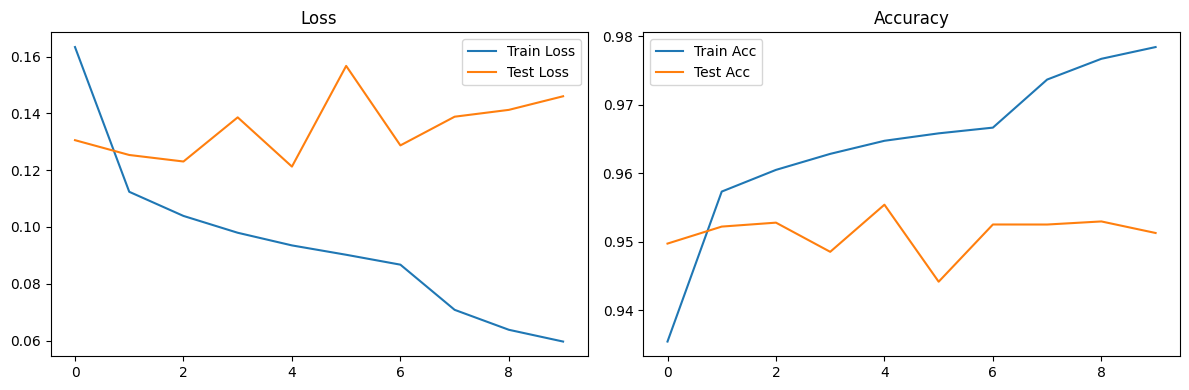

In [9]:
# Загружаем лучшую модель для оценки
model.load_state_dict(torch.load('best_model_pytorch.pt'))

# --- Предсказания и отчеты по классификации ---
def get_predictions(model, loader):
    model.eval()
    all_preds = []
    with torch.no_grad():
        for text, _ in loader:
            predictions = model(text).squeeze(1)
            rounded_preds = torch.round(predictions)
            all_preds.extend(rounded_preds.cpu().numpy())
    return np.array(all_preds)

test_predictions = get_predictions(model, test_loader)
print(classification_report(test_output, test_predictions, target_names=lbl_target.classes_))

plot_training_history(history)

In [16]:
# Тестирование на новом тексте
def predict_sentiment(text, model, tokenizer, max_len, label_encoder, device):
    cleaned_text, _ = clean_text([text])
    sequence = tokenizer.texts_to_sequences(cleaned_text)
    padded_sequence = np.array([np.pad(seq[:max_len], (0, max(0, max_len - len(seq))), 'constant', constant_values=0)
                                for seq in sequence])

    input_tensor = torch.LongTensor(padded_sequence).to(device)

    model.eval()
    with torch.no_grad():
        prediction = model(input_tensor).item()

    print(f"\nПредсказанная вероятность: {prediction:.4f}")

    if prediction > 0.5:
        print("Есть признаки депрессивного поведения.")
    else:
        print("Признаков депрессии нет.")

    return prediction

# Пример 1
twt_1 = ["I'm a lonely 22 year old guy and feeling like a loser with no future.I'm 22 and feel all alone and I am very insecure about myself. I'm a fat 6'3'' 260 pound guy with a really small 5.5 inch penis. I have no gf or any experience with girls cause I feel too ugly and I think they will laugh at my size."]
predict_sentiment(twt_1[0], model, tokenizer, MAX_LEN, lbl_target, DEVICE)

# Пример 2
twt_2 = ["my school sucks. i try not to litter, but it feels impossible because even when i bring a reusable mask, the school requires two disposable masks. i can't give them away, i can't do anything with them, and two of my siblings go to the same school. if i do the math, that's like 30 disposable masks a week. i hate it."]
predict_sentiment(twt_2[0], model, tokenizer, MAX_LEN, lbl_target, DEVICE)


Предсказанная вероятность: 0.8140
Есть признаки депрессивного поведения.

Предсказанная вероятность: 0.0008
Признаков депрессии нет.


0.0008094141958281398